# Selection of krypton events in terms of S1 and S2

## Authors: JMH, JAH, GML, JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

### Description:

- run = 6365


In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Wed Apr 24 21:08:24 2019


In [2]:
run_number  = 6365
file_range  = 0, 9947 
num_files = 9947
tags        = 'v0.9.9_20180921_krth'

if num_files > 7729:
    num_xy_bins = 100
else:
    num_xy_bins = 50

t0 = time.time()
last_time = t0

input_path  = f"$IC_DATA/kdst"
output_path = f"$IC_DATA/dst"
log_path    = f"$IC_DATA/log"
trigger     = 'trigger1'
summary_outputs = "/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r"+str(run_number)+"/"

bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6165.h5"
write_filtered_dst = True

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [4]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import tables            as tb
import random
import glob
import seaborn as sns
sns.set()

In [5]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units


In [6]:
from krcal.core.io_functions       import filenames_from_paths
from krcal.core.io_functions       import write_monitor_vars
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2d, plot_histo

In [7]:
from krcal.core.kr_types           import PlotLabels
from krcal.core.ranges_and_bins_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions import kr_event
from krcal.core.analysis_functions import selection_info
from krcal.core.analysis_functions import selection_in_band
from krcal.core.analysis_functions import plot_selection_in_band
from krcal.core.s1s2_functions     import s1d_from_dst
from krcal.core.s1s2_functions     import s2d_from_dst
from krcal.core.s1s2_functions     import plot_s1histos
from krcal.core.s1s2_functions     import plot_s2histos

In [8]:
from krcal.core.plt_functions      import plot_xy_density
from krcal.core.plt_functions      import plot_s1_vs_z
from krcal.core.plt_functions      import plot_s2_vs_z
from krcal.core.plt_functions      import plot_s2_vs_s1
from krcal.core.plt_functions      import plot_q_vs_s2
from krcal.core.plt_functions      import plot_energy_distributions
from krcal.core.plt_functions      import plot_energy_vs_t


In [9]:
import krcal.dev.corrections       as corrections 
import krcal.utils.hst_extend_functions as hst

In [10]:
from krcal.core.core_functions          import time_delta_from_time

### Create vals file

In [11]:
# vals
import subprocess

In [12]:
# vals
vals_dir_loc = '/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/data_'+str(run_number)+'/'
bash_mkdir = "mkdir " + vals_dir_loc
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

In [13]:
# vals
vals_loc = vals_dir_loc + 'vals_'+str(run_number)+'.txt'
bash_touch = "touch " + vals_loc
process = subprocess.Popen(bash_touch, stdout=subprocess.PIPE, shell=True).wait()

In [14]:
# vals
summary_vals = open(vals_loc, 'w') # start by erasing the old file, then just append in later use.
summary_vals.write('runNumber='+str(run_number)+'\n')
summary_vals.write('lastFile='+str(file_range[1])+'\n')
summary_vals.close()

### Input/output 

In [15]:
input_dst_filenames, output_dst_filename, log_filename = filenames_from_paths(run_number,
                                                                              input_path,
                                                                              output_path,
                                                                              log_path,
                                                                              trigger,
                                                                              tags,
                                                                              file_range)
                                                                              
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"log file   = {log_filename}")           

print('time before dst load =', round(time.time() - last_time))
last_time = time.time()

input dsts:
 first = /Volumes/NEXT_data/IC_Data//kdst/6365/kdst_0000_6365_trigger1_v0.9.9_20180921_krth.h5
 last = /Volumes/NEXT_data/IC_Data//kdst/6365/kdst_9946_6365_trigger1_v0.9.9_20180921_krth.h5
output dst = /Volumes/NEXT_data/IC_Data//dst/dst_6365_trigger1_0000_9946.h5
log file   = /Volumes/NEXT_data/IC_Data//log/log_6365_trigger1_0000_9946.h5
time before dst load = 3


In [16]:
dst_full           = load_dsts(input_dst_filenames, "DST", "Events")
print('time to load dst =', round(time.time() - last_time))
last_time = time.time()

time to load dst = 302


In [17]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

# vals
summary_vals = open(vals_loc, 'a')
summary_vals.write(f'totalNumS2={number_of_S2s_full}\n')
summary_vals.write(f'totalNumEvt={number_of_evts_full}\n')
summary_vals.close()

Total number of S2s   : 4857613 
Total number of events: 2718649


In [18]:
dst_full.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [19]:
ntot = len(dst_full)
print(f"length of dst = {ntot}")

length of dst = 4857613


### S1/S2

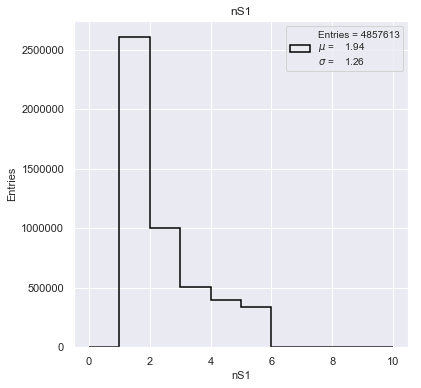

In [20]:
n, b, _, _ = h1d(dst_full.nS1.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS1', y='Entries', title='nS1'))

In [21]:
fnS1 = n[n.argmax()]/np.sum(n)
print(f'fraction of S1s = {fnS1}')

fraction of S1s = 0.5376264021032552


#### Fraction of events with 1 S1 is 0.5, due to grass and high energy events. For Krypton select events with 1 S1

### Select events with 1 S1

In [22]:
dst1s1 = dst_full[dst_full.nS1==1]

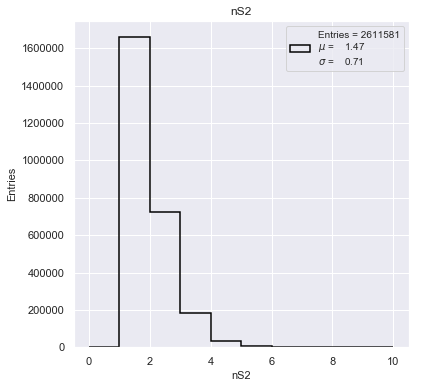

In [23]:
n, b, _, _ = h1d(dst1s1.nS2.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS2', y='Entries', title='nS2'))

#### For Krypton select events with only 1 S2

In [24]:
fnS2 = n[n.argmax()]/np.sum(n)
print(f'fraction of S2s = {fnS2}')

fraction of S2s = 0.6363172346559421


### Select events with 1 S2

In [25]:
dst    = dst1s1[dst1s1.nS2==1]

In [26]:
n_full   = len(dst)
eff = n_full   / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {n_full}: selection eff = {eff} ")

# vals
summary_vals = open(vals_loc, 'a')
summary_vals.write(f'fracS1={round(fnS1,2)}\n')
summary_vals.write(f'fracS2={round(fnS2,2)}\n')
summary_vals.write(f'fracS1S2={round(eff,2)}\n')
summary_vals.close()

Total number of events with 1 s1 and 1 s2 : 1661794: selection eff = 0.342100945464367 


### S1 and S2 distributions

In [27]:
s1d = s1d_from_dst(dst)

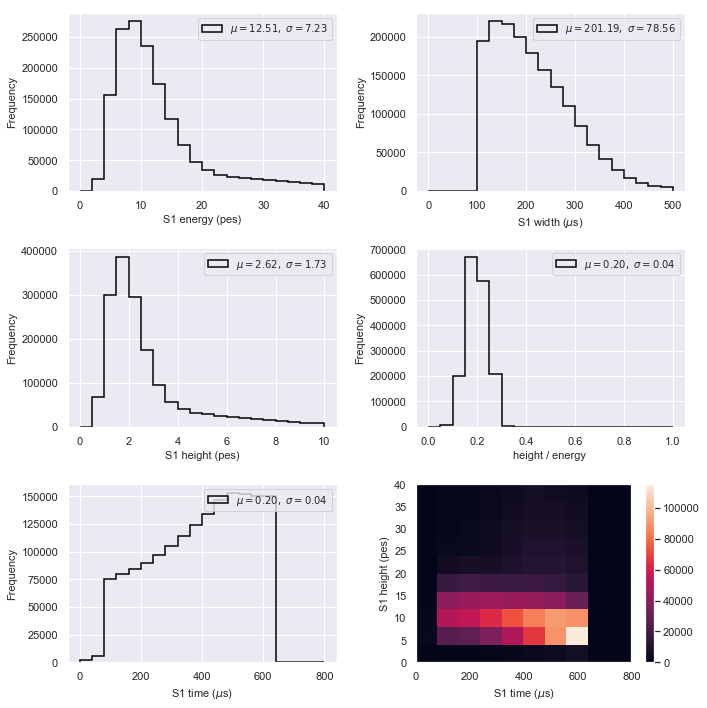

In [28]:
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))
plt.savefig(summary_outputs+'s1.png')

### Fiducial selection in S1

#### 2 < S1e < 25 pes, which cuts off very low and high energy events

In [29]:
s1e_range =(3, 25)

# vals
summary_vals = open(vals_loc, 'a')
summary_vals.write(f's1Min={s1e_range[0]}\n')
summary_vals.write(f's1Max={s1e_range[1]}\n')
summary_vals.close()

In [30]:
dst_s1e    = dst[in_range(dst.S1e, *s1e_range)] 

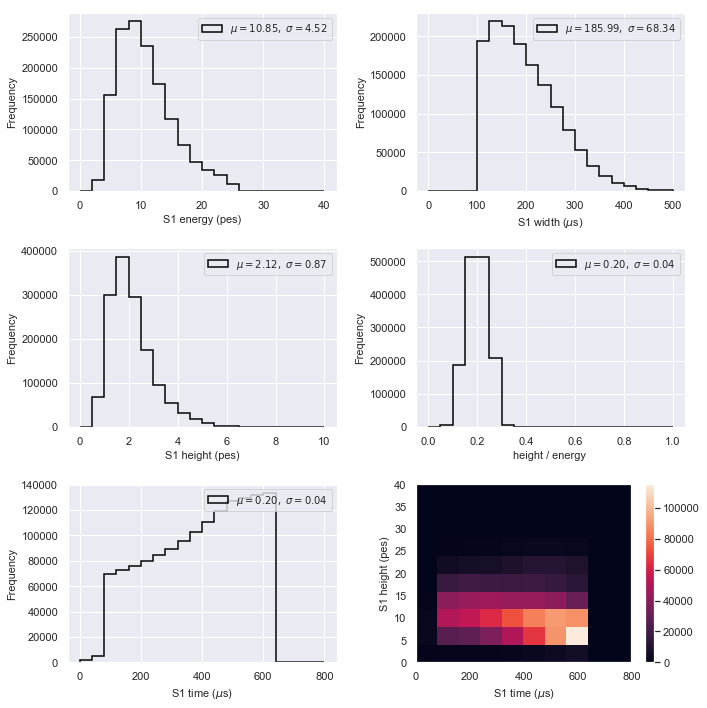

In [31]:
s1d = s1d_from_dst(dst_s1e, range_s1e = s1e_range)
plot_s1histos(dst_s1e,  s1d, bins=20, figsize=(10,10))

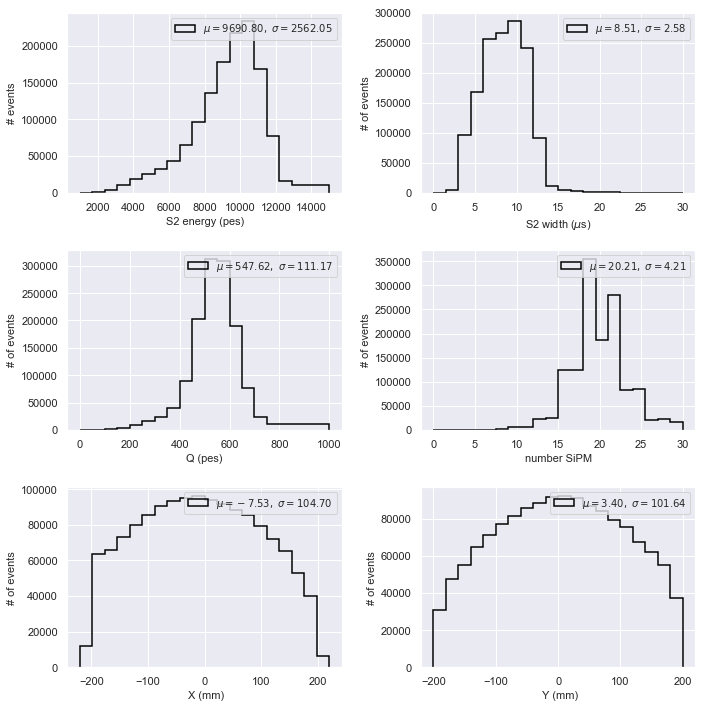

In [32]:
dst = dst_s1e
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))
plt.savefig(summary_outputs+'s2.png')

### Fiducial selection in S2

In [33]:
Nsipm_min = 15 
s2e_range =(3000, 13000)
s2w_range =(5, 15)
s2q_range =(200, 800)

# vals
summary_vals = open(vals_loc, 'a')
summary_vals.write(f's2MinPMT={s2e_range[0]}\n')
summary_vals.write(f's2MaxPMT={s2e_range[1]}\n')
summary_vals.write(f's2MinQ={s2q_range[0]}\n')
summary_vals.write(f's2MaxQ={s2q_range[1]}\n')
summary_vals.write(f'widthMin={s2w_range[0]}\n')
summary_vals.write(f'widthMax={s2w_range[1]}\n')
summary_vals.write(f'numSipmMin={Nsipm_min}\n')
summary_vals.close()

In [34]:
dst_sipm    = dst[dst.Nsipm >Nsipm_min] 
dst_s2e    = dst_sipm[in_range(dst_sipm.S2e, *s2e_range)] 
dst_s2w    = dst_s2e[in_range(dst_s2e.S2w, *s2w_range)]
dst_s2q    = dst_s2w[in_range(dst_s2w.S2q, *s2q_range)]
dst = dst_s2q

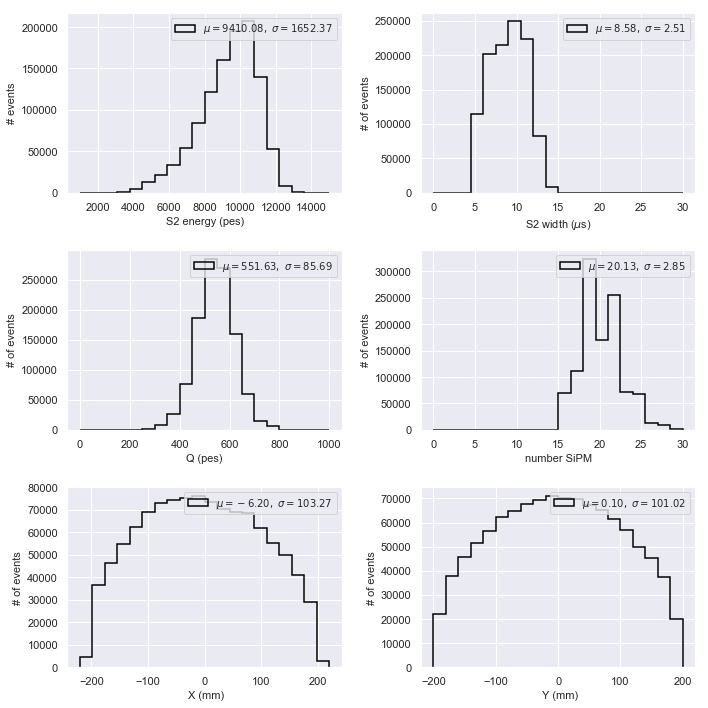

In [35]:
s2d = s2d_from_dst(dst_s2e)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

### Time differences in seconds

In [36]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Define ranges and bins

In [37]:
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = (-220,  220),
                                                        yrange    = (-220,  220),
                                                        zrange    = (10,  550),
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = num_xy_bins,
                                                        ynbins    = num_xy_bins,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 50,
                                                        s2qnbins  = 50,
                                                        tpsamples = 3600) # tsamples in seconds

### Time
- Extension in hours of data sample considered

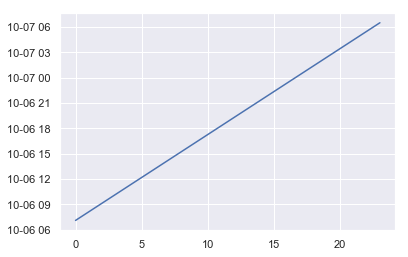

In [38]:
plt.plot(krTimes.timeStamps)
plt.savefig(summary_outputs+'runTime.png')

In [39]:
# vals
full_final_datetime = str(krTimes.timeStamps[-1])
final_date = full_final_datetime[:full_final_datetime.find(' ')]

# Once you have the date, find the temperature on that date.
import codecs

ctrl = 'SNS'

def itemize(line):
    items = []
    while len(line) > 0:
        if not line.find('\t') == -1:
            potential_item = line[:line.find('\t')]
            potential_item = potential_item.strip()
            if not potential_item == "":
                items.append(potential_item)
            line = line[line.find('\t')+1:]
        elif line.find('\n') == -1:
            items.append(line)
            line = ""
        else:
            line = ""
    return items

vessel_temps = []
param_of_interest = "NEW"

text_path = "/Users/jmhaefner/Dropbox/Data/" + ctrl + "_Data_Report_" + final_date + ".txt"

data_file = codecs.open(text_path, 'r', encoding='ISO-8859-1')
data_lines = data_file.readlines()

parameters = itemize(data_lines[2])
first_data = itemize(data_lines[3])

for i in range(len(parameters)):
    try:
        print_params = parameters[i]+'='+first_data[i]
        #print(print_params)
    except:
        # print('Failed to find a value for param', [parameters[i]])
        parameters.pop(i)
        i -= 1

for i in range(len(parameters)):
    for j in range(3,len(data_lines)):
        if parameters[i] == param_of_interest:
            itemized = itemize(data_lines[j])
            value = float(itemized[i].replace(',', '.'))
            vessel_temps.append(value)

day_temp = sum(vessel_temps)/(1.0 * len(vessel_temps))
print('The day temp on '+final_date+' was '+str(round(day_temp,1)))

summary_vals = open(vals_loc, 'a')
summary_vals.write('date='+final_date+'\n')
summary_vals.write('labTempC='+str(round(day_temp,1))+'\n')
summary_vals.close()

The day temp on 2018-10-07 was 21.8


In [40]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

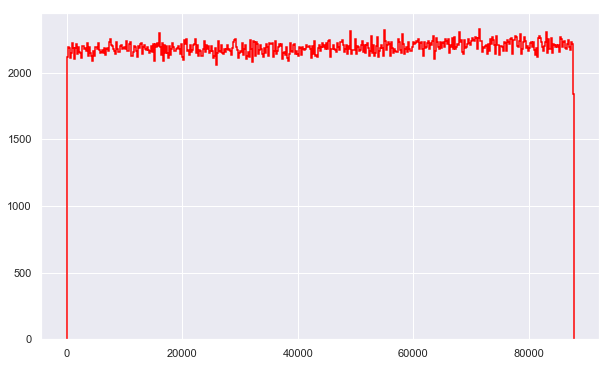

In [41]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')
plt.savefig(summary_outputs+'runEvt.png')

### Control distributions

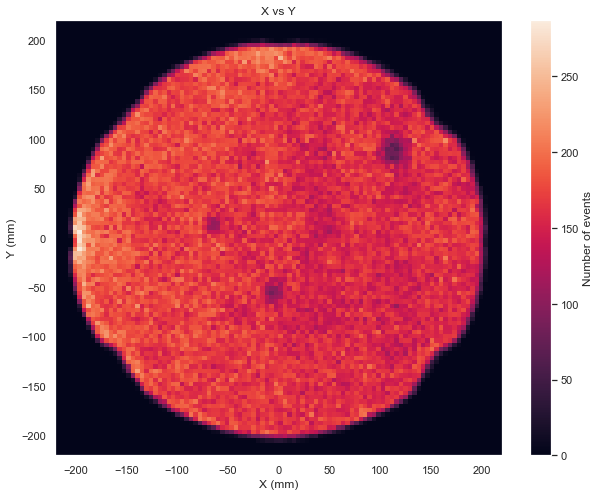

In [42]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))
plt.savefig(summary_outputs+'xy.png')

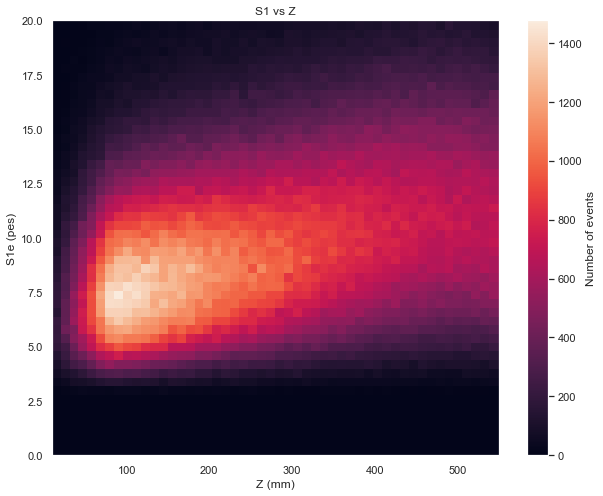

In [43]:
nevt = h2d(dst.Z, dst.S1e, krNbins.Z, krNbins.S1e, krRanges.Z, (0,20), 
           pltLabels=PlotLabels(x='Z (mm)', y='S1e (pes)', title='S1 vs Z'),
           profile=False,
           figsize=(10,8))

#### S1 vs Z distribution:

- Concentrated at low Z: This is due to the fact that gas flow is higher near the anode, and thus there is more krypton near the anode than near the cathode. 
- Increases as a function of Z. The closer to the cathode the larger S1
- Spread is large: This is due to large variation of solid angle, depending on (X,Y)

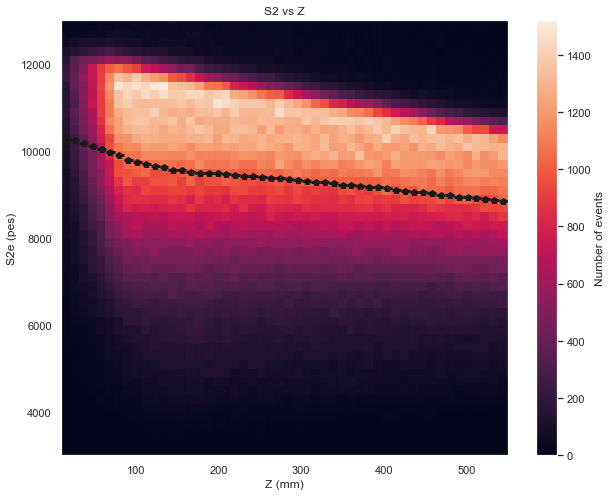

In [44]:
nevt = h2d(dst.Z, dst.S2e, krNbins.Z, krNbins.S1e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

#### S2 vs Z distribution:

- Concentrated at low Z: This is due to the fact that gas flow is higher near the anode, and thus there is more krypton near the anode than near the cathode. 
- Decreases as a function of Z, due to lifetime
- Spread is large: This is due to large variation of solid angle, depending on (X,Y)

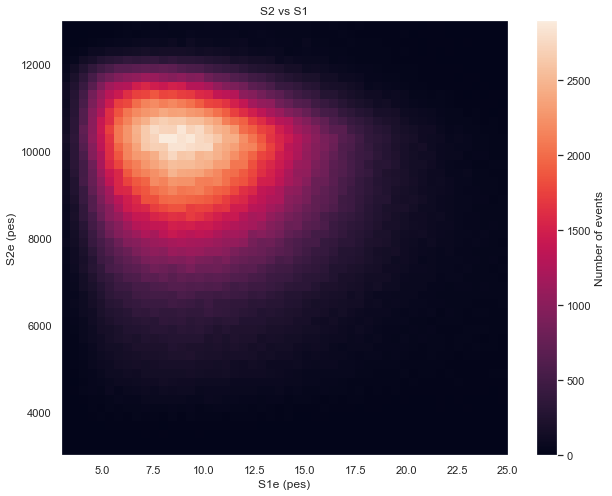

In [45]:
nevt = h2d(dst.S1e, dst.S2e, krNbins.S1e, krNbins.S2e, krRanges.S1e, krRanges.S2e, 
           pltLabels=PlotLabels(x='S1e (pes)', y='S2e (pes)', title='S2 vs S1'),
           profile=False,
           figsize=(10,8))

#### S2 vs S1 distribution:

- Small anti-correlation (more S2 less S1). 

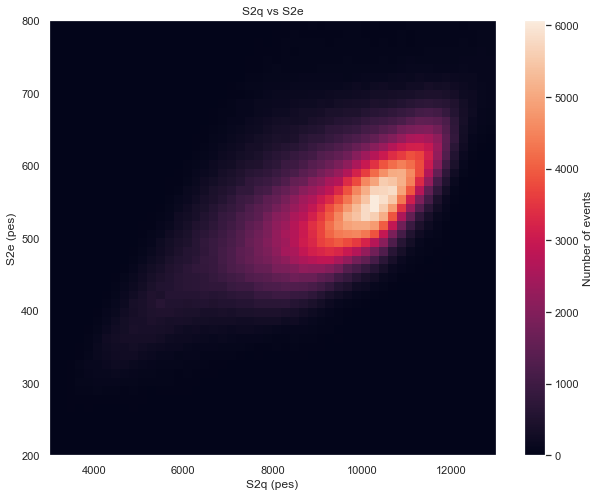

In [46]:
nevt = h2d(dst.S2e, dst.S2q, krNbins.S2e, krNbins.S2q, krRanges.S2e, krRanges.S2q, 
           pltLabels=PlotLabels(x='S2q (pes)', y='S2e (pes)', title='S2q vs S2e'),
           profile=False,
           figsize=(10,8))

#### S2 vs Q distribution:

- Clear correlation between S2 and Q 

### Select central region in R 

#### The effect is to reduce the dependence of geometrical corrections

In [47]:
dst_R     = dst[dst.R < 100]

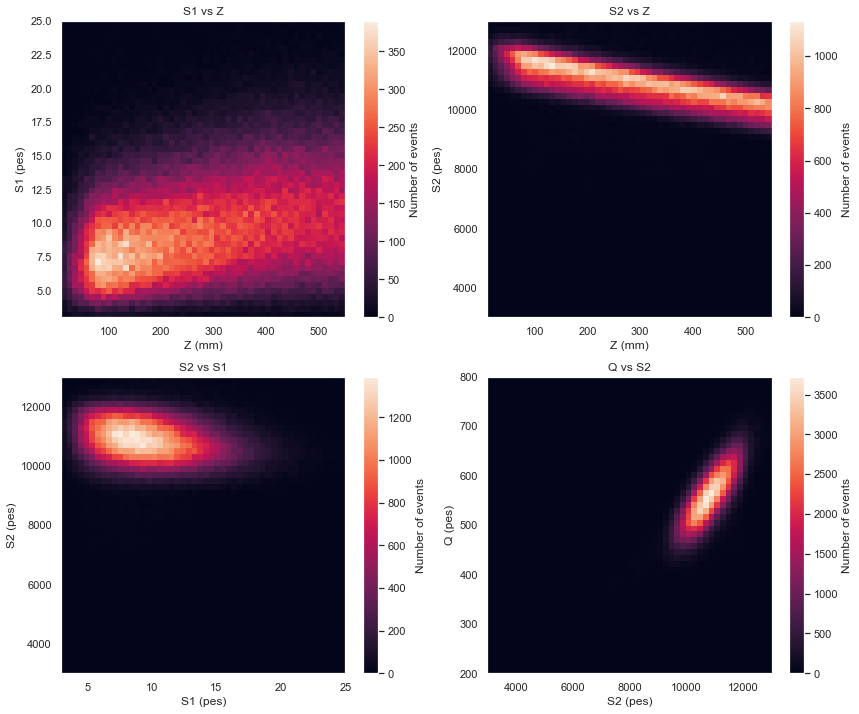

In [48]:
plot_energy_distributions(dst_R, krBins.Z, krBins.S1e, krBins.S2e, krBins.S2q, figsize=(14,12))
plt.savefig(summary_outputs+'s1s2q.png')

### Select central region in Z

- The effect is to reduce the dependence of lifetime

In [49]:
dst_core     = dst_R[dst_R.Z < 200]

### Energy in core

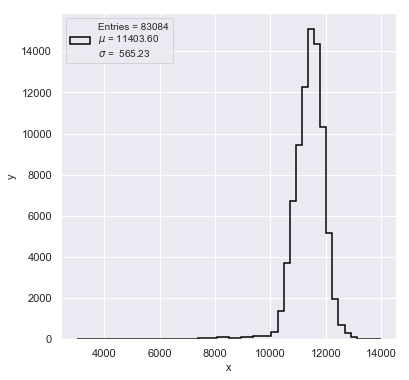

In [50]:
(_) = h1d(dst_core.S2e, bins = 50, range =(3000,14000), legendloc='upper left')

### Apply bootstrap corrections.

- One can correct S2e and S2q by geometrical corrections using an existing map (a bootstrap map). This has the effect to reduce the geometrical dependence on both distributions, permitting an additional filtering

In [51]:
kre = kr_event(dst)

In [52]:
bootstrap_correction_filename = os.path.expandvars(bootstrap_correction_filename)
calibrate = corrections.Calibration(bootstrap_correction_filename)
E, Q = calibrate(kre.X, kre.Y, None, kre.T, kre.S2e, kre.S2q)

In [53]:
kge = kr_event(dst, DT, E, Q)

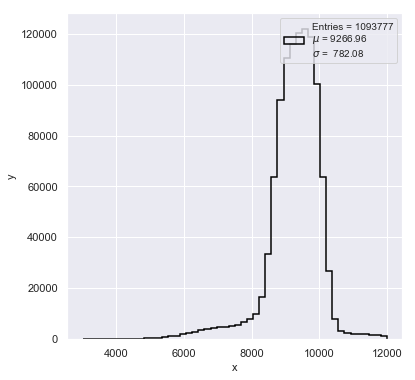

In [54]:
(_) = h1d(kge.E, bins = 50, range =(3000,12000))

#### Plot of E and Q corrected vs Z shows much less spread (XY corrections applied only remaining LT corrections)

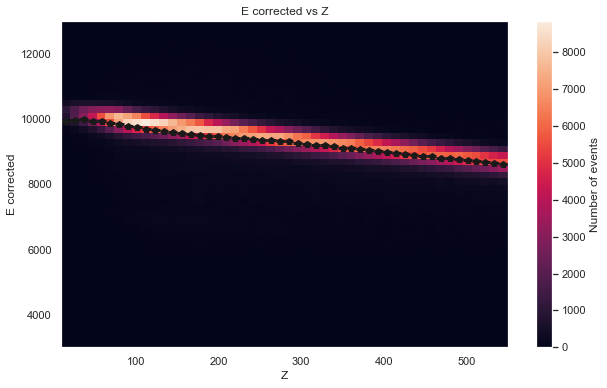

In [55]:
nevt = h2d(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z', y='E corrected', title='E corrected vs Z'),
           profile=True,
           figsize=(10,6))

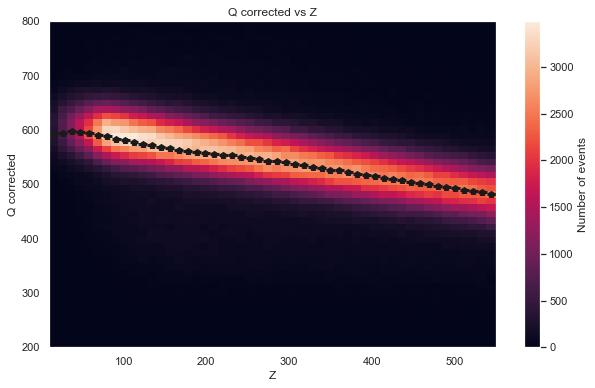

In [56]:
nevt = h2d(dst.Z, Q, krNbins.Z, krNbins.S2q, krRanges.Z, krRanges.S2q, 
           pltLabels=PlotLabels(x='Z', y='Q corrected', title='Q corrected vs Z'),
           profile=True,
           figsize=(10,6))

### Filter

In [57]:
range_krs2 = (7e+3,12e+3)

In [58]:
num_bins = 50
num_in_band = 0
while num_in_band == 0 and num_bins >= 5:
    sel_krband, fpl, fph, hp, pp = selection_in_band(kre.Z, E,
                                                     range_z = krRanges.Z,
                                                     range_e = range_krs2,
                                                     nbins_z = num_bins,
                                                     nbins_e = num_bins,
                                                     nsigma  = 3.5)
    readout = selection_info(sel_krband, 'Kr band')
    readout = readout[readout.find(': ')+2:]
    readout = readout[:readout.find(' ')]
    num_in_band = int(readout)
    num_bins -= 1
print('Final number of bins =', num_bins)

Total number of selected candidates Kr band: 971028 (88.8 %)
Final number of bins = 49


/Users/jmhaefner/Development/KryptonCalibration/KrCalibTEMP/ICAROS/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalibTEMP/ICAROS/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)


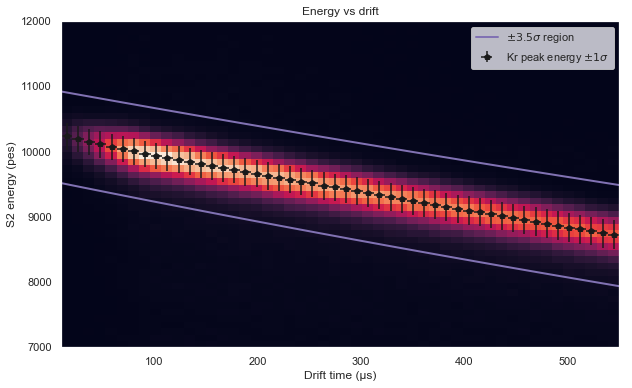

In [59]:
plot_selection_in_band(fpl, fph, hp, pp)

In [60]:
selection_info(sel_krband, 'Kr band')

Total number of selected candidates Kr band: 971028 (88.8 %)


'Total number of selected candidates Kr band: 971028 (88.8 %)'

In [61]:
kges = kr_event(dst, DT, E, Q, sel_mask=sel_krband)

### Energy before and after filter

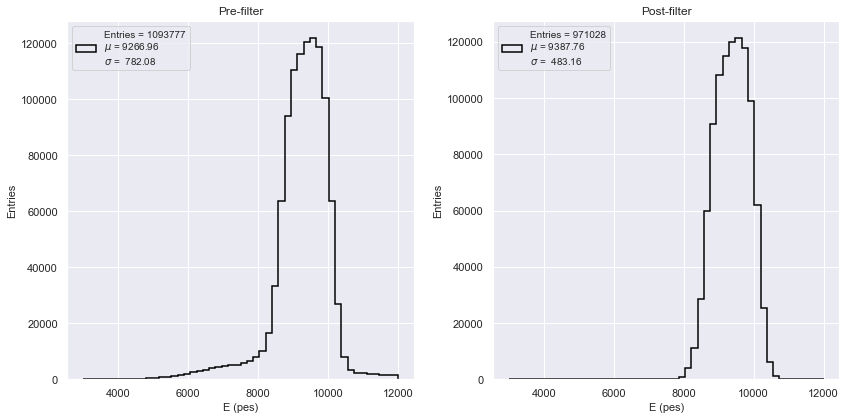

In [62]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(kge.E,  bins = 50, range =(3000,12000))
plot_histo(PlotLabels('E (pes)','Entries','Pre-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(kges.E,  bins = 50, range =(3000,12000))
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
plt.tight_layout()

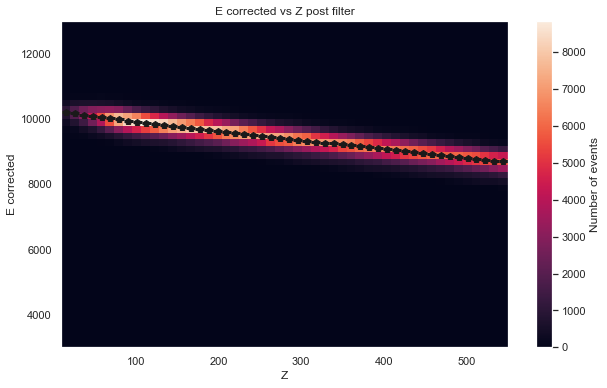

In [63]:
nevt = h2d(kges.Z, kges.E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z', y='E corrected', title='E corrected vs Z post filter'),
           profile=True,
           figsize=(10,6))

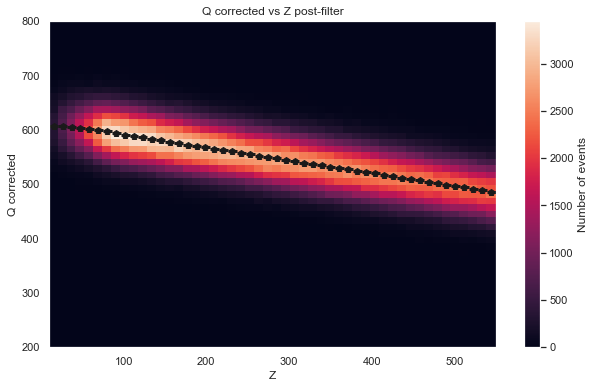

In [64]:
nevt = h2d(kges.Z, kges.Q, krNbins.Z, krNbins.S2q, krRanges.Z, krRanges.S2q, 
           pltLabels=PlotLabels(x='Z', y='Q corrected', title='Q corrected vs Z post-filter'),
           profile=True,
           figsize=(10,6))

#### Notice how the filter cleans up the energy distributions. 

### Time evolution

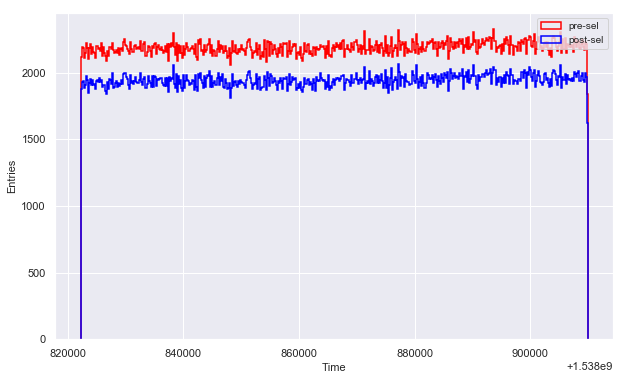

In [65]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.T, bins=500, range = (kge.T.min(), kge.T.max()), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('Time','Entries',''), ax)
(_)    = h1(kges.T, bins=500, range = (kges.T.min(), kges.T.max()), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('Time','Entries',''), ax)

#### event density is constant, indicating a stable run

### S1 and Corrected E and Q as a function of T

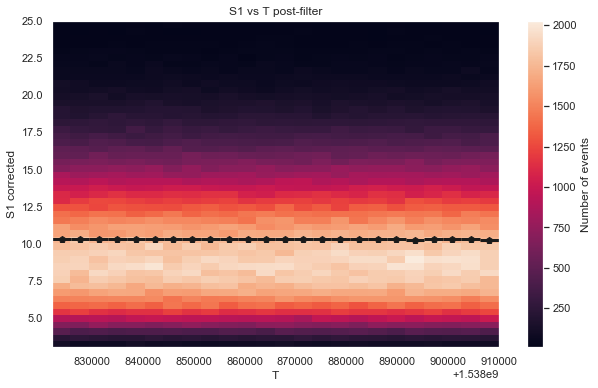

In [66]:
nevt = h2d(kges.T, kges.S1e, krNbins.T, krNbins.S1e, krRanges.T, krRanges.S1e, 
           pltLabels=PlotLabels(x='T', y='S1 corrected', title='S1 vs T post-filter'),
           profile=True,
           figsize=(10,6))

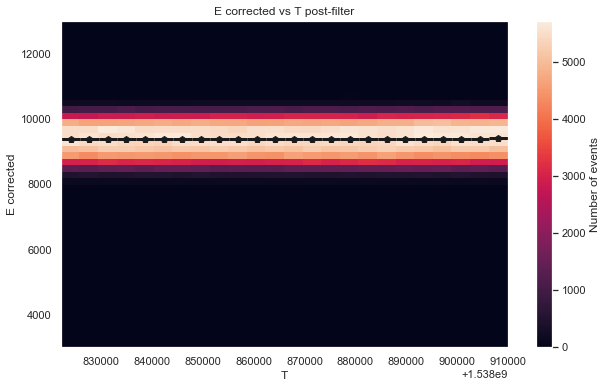

In [67]:
nevt = h2d(kges.T, kges.E, krNbins.T, krNbins.S2e, krRanges.T, krRanges.S2e, 
           pltLabels=PlotLabels(x='T', y='E corrected', title='E corrected vs T post-filter'),
           profile=True,
           figsize=(10,6))

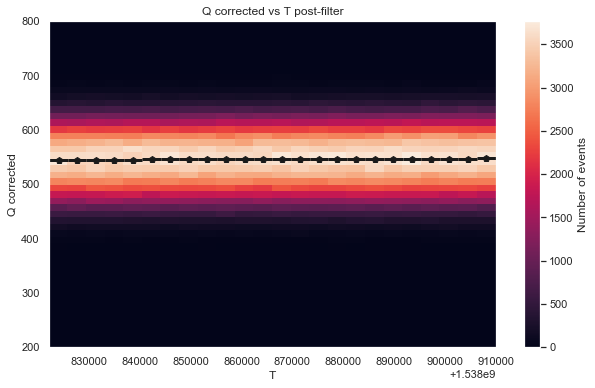

In [68]:
nevt = h2d(kges.T, kges.Q, krNbins.T, krNbins.S2q, krRanges.T, krRanges.S2q, 
           pltLabels=PlotLabels(x='T', y='Q corrected', title='Q corrected vs T post-filter'),
           profile=True,
           figsize=(10,6))

### All amplitudes are constant as a function of time in an stable run

### Select dst 

In [69]:
dsts = dst[sel_krband]

### X vs Y again

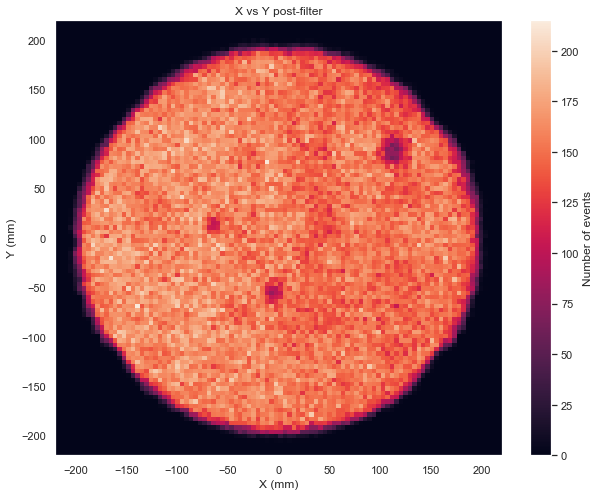

In [70]:
nevt = h2d(dsts.X, dsts.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y post-filter'),
           profile=False,
           figsize=(10,8))

### Spatial distributions 

#### In R and Z

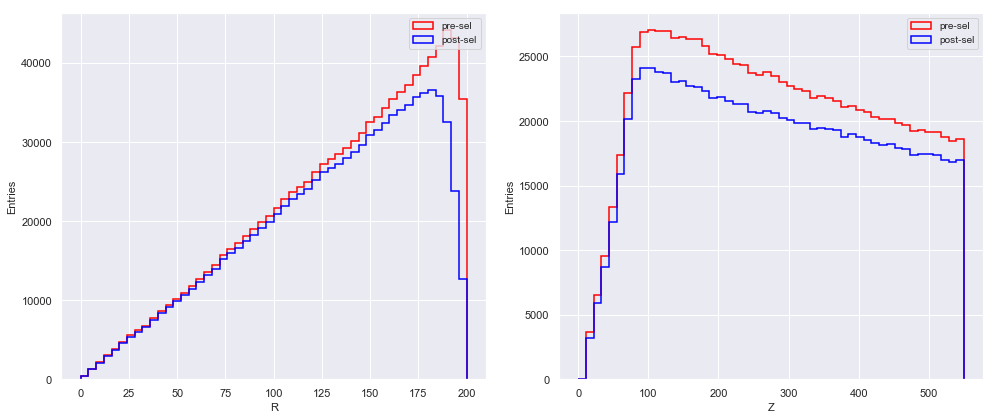

In [71]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
(_)    = h1(kge.R, bins=50, range = (0,200), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('R','Entries',''), ax)
(_)   = h1(kges.R, bins=50, range = (0,200), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('R','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
(_)    = h1(kge.Z, bins=50, range = (0,550), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('Z','Entries',''), ax)
(_)    = h1(kges.Z, bins=50, range = (0,550), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('Z','Entries',''), ax)
plt.tight_layout()

#### In X Y

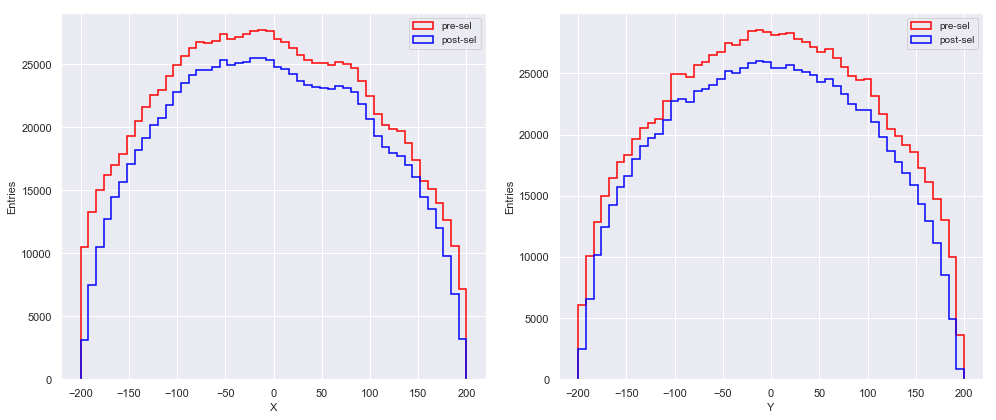

In [72]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
(_)    = h1(kge.X, bins=50, range = (-200,200), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('X','Entries',''), ax)
(_)    = h1(kges.X, bins=50, range = (-200,200), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('X','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
(_)    = h1(kge.Y, bins=50, range = (-200,200), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('X','Entries',''), ax)
(_)    = h1(kges.Y, bins=50, range = (-200,200), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('Y','Entries',''), ax)
plt.tight_layout()

### Charge and SiPM distributions

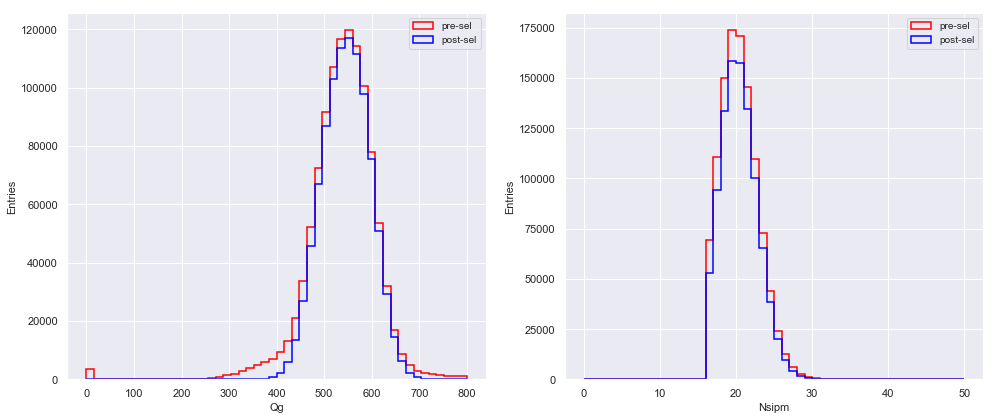

In [73]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
(_)    = h1(kge.Q, bins=50, range = (0,800), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('Qg','Entries',''), ax)
(_)    = h1(kges.Q, bins=50, range = (0,800), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('Qg','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
(_)    = h1(dst.Nsipm, bins=50, range = (0,50), color='red', stats=False, lbl='pre-sel')
plot_histo(PlotLabels('Nsipm','Entries',''), ax)
(_)    = h1(dsts.Nsipm, bins=50, range = (0,50), color='blue',stats=False, lbl='post-sel')
plot_histo(PlotLabels('Nsipm','Entries',''), ax)
plt.tight_layout()

### Write DST (merged and fiducial)

In [74]:
dst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [75]:
#del dst['index']
print('Time after loading to before writing =', round(time.time() - last_time))
last_time = time.time()

Time after loading to before writing = 44


In [76]:
if (write_filtered_dst):
    print('writing filtered dst ', output_dst_filename)
    kdst_write(dsts, output_dst_filename);
print('Time to write =', round(time.time() - last_time))
print('Full notebook time =', round(time.time() - t0))

writing filtered dst  /Volumes/NEXT_data/IC_Data//dst/dst_6365_trigger1_0000_9946.h5


Time to write = 84
Full notebook time = 433


## End of NB